In [1]:
import pandas as pd
import numpy as np
import ast
import json
from typing import Optional, Tuple

def get_balanced_samples(df: pd.DataFrame, 
                        n_per_class: Optional[int] = None,
                        train_fraction: float = 0.8,
                        random_state: Optional[int] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Randomly sample an equal number of records where hallucinated is True and False,
    split into training and test sets, and format prompts for each row.
    
    Args:
        df (pd.DataFrame): Input DataFrame with 'hallucinated', 'question', and 'options' columns
        n_per_class (int, optional): Number of samples to take from each class.
                                   If None, uses the size of the smaller class.
        train_fraction (float): Fraction of data to use for training (default: 0.8)
        random_state (int, optional): Random seed for reproducibility
    
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (train_df, test_df) containing balanced samples
                                         with formatted prompts
    """
    if not 0 < train_fraction < 1:
        raise ValueError("train_fraction must be between 0 and 1")
    
    # Ensure hallucinated column is boolean
    df = df.copy()

    # Filter by activation if the column exists
    if 'activation' in df.columns:
        original_len = len(df)
        df = df[df['activation'] == 0]
        filtered_len = len(df)

        if filtered_len == 0:
            raise ValueError("No rows remaining after filtering activation = 0")

    # Ensure hallucinated column is boolean
    df['hallucinated'] = df['hallucinated'].astype(bool)
    
    # Split into True and False groups
    true_samples = df[df['hallucinated'] == True]
    false_samples = df[df['hallucinated'] == False]
    
    # Get counts
    n_true = len(true_samples)
    n_false = len(false_samples)
    
    # If n_per_class not specified, use size of smaller group
    if n_per_class is None:
        n_per_class = min(n_true, n_false)
    
    # Verify we have enough samples
    if n_per_class > min(n_true, n_false):
        raise ValueError(f"Requested {n_per_class} samples per class but smallest class only has {min(n_true, n_false)} samples")
    
    # Sample from each group
    sampled_true = true_samples.sample(n=n_per_class, random_state=random_state)
    sampled_false = false_samples.sample(n=n_per_class, random_state=random_state)
    
    # Calculate number of training samples (ensuring even split between classes)
    n_train_per_class = int(n_per_class * train_fraction)
    
    # Split each class into train and test
    train_true = sampled_true.iloc[:n_train_per_class]
    test_true = sampled_true.iloc[n_train_per_class:]
    
    train_false = sampled_false.iloc[:n_train_per_class]
    test_false = sampled_false.iloc[n_train_per_class:]
    
    # Combine and shuffle train and test sets
    train_df = pd.concat([train_true, train_false])
    train_df = train_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    test_df = pd.concat([test_true, test_false])
    test_df = test_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    # Format prompts for both datasets
    def format_prompts(df):
        introduction = ("You are a medical expert and this is a multiple choice exam question. "
                       "Please respond with the integer index of the CORRECT answer only; [0,1,2,3].")
        
        formatted_df = df.copy()
        formatted_prompts = []
        
        for _, row in df.iterrows():
            question = row['question']
            
            # Parse options
            if isinstance(row['options'], str):
                options_dict = ast.literal_eval(row['options'])
            elif isinstance(row['options'], list) and len(row['options']) > 0:
                options_dict = row['options'][0]
            else:
                options_dict = row['options']
            
            # Filter out 'correct answer' from options
            options_filtered = {k: v for k, v in options_dict.items() if k != 'correct answer'}
            options_formatted = "Options: " + json.dumps(options_filtered)
            
            # Construct prompt
            prompt = f"{introduction}\n\n{question}\n\n{options_formatted}"
            formatted_prompts.append(prompt)
        
        formatted_df['prompt'] = formatted_prompts
        return formatted_df
    
    # Apply prompt formatting to both datasets
    train_df = format_prompts(train_df)
    test_df = format_prompts(test_df)
    
    print(f"Created balanced samples with {n_per_class} records per class")
    print(f"Training set: {len(train_df)} records ({n_train_per_class} per class)")
    print(f"Test set: {len(test_df)} records ({n_per_class - n_train_per_class} per class)")
    print("\nClass distribution in training set:")
    print(train_df['hallucinated'].value_counts())
    print("\nClass distribution in test set:")
    print(test_df['hallucinated'].value_counts())
    
    return train_df, test_df

In [4]:
file_path = '../data/fct_responses_clean.tsv'

# Read the TSV file
df = pd.read_csv(file_path, sep='\t')

# Get balanced samples with train/test split
train_data, test_data = get_balanced_samples(
    df=df,
    n_per_class=125,
    train_fraction=0.8,
    random_state=42
)


Created balanced samples with 125 records per class
Training set: 200 records (100 per class)
Test set: 50 records (25 per class)

Class distribution in training set:
hallucinated
True     100
False    100
Name: count, dtype: int64

Class distribution in test set:
hallucinated
True     25
False    25
Name: count, dtype: int64


In [3]:
import goodfire
import os

api_key ='sk-goodfire-9IJgLomji2zNdvFLPsTYPQvPPr_kUC19bFTh0HgT9h6SikyfPB7WmQ'
client  = goodfire.Client(api_key)
variant = goodfire.Variant("meta-llama/Meta-Llama-3-8B-Instruct")

In [6]:
hallucinated_examples = train_data[train_data['hallucinated'] == True]
truthful_examples     = train_data[train_data['hallucinated'] == False]

dataset_1 = [
    [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": "3"}
    ] for prompt in hallucinated_examples['prompt'].tolist()
]

dataset_2 = [
    [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": "3"}
    ] for prompt in truthful_examples['prompt'].tolist()
]

hallucinated_features, truthful_features = client.features.contrast(
    dataset_1=dataset_1,
    dataset_2=dataset_2,
    dataset_1_feature_rerank_query="medical response hallucinated",
    dataset_2_feature_rerank_query="medical response truthful",
    model=variant,
    top_k=50
)
features_to_look_at = hallucinated_features | truthful_features
features_to_look_at

ReadTimeout: The read operation timed out

In [6]:
from itertools import combinations

class FeatureMixer:
  def __init__(self, feature_group):
    self.feature_group = feature_group

  def grid(self, k_features_per_combo: int =2):
    """Perform a grid search over all possible combinations of features"""

    # Get all possible combinations of features
    return list(combinations(self.feature_group, k_features_per_combo))

In [7]:
import pandas as pd
import concurrent.futures as futures
import tqdm


MIN_SAMPLES_PER_CLASS = min(
    len(hallucinated_examples),
    len(truthful_examples),
)

print(f"MIN_SAMPLES_PER_CLASS: {MIN_SAMPLES_PER_CLASS}")

MAX_WORKERS = 3

def _get_feature_acts_for_sample_class(
    sample_class: pd.DataFrame,
    features_to_use_for_classification: goodfire.FeatureGroup,
    k=100,):

    if k < len(features_to_use_for_classification):
        raise ValueError("k must be greater than the number of features to use for classification")

    samples = []
    with futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures_list = []
        for idx, row in sample_class[0:MIN_SAMPLES_PER_CLASS].iterrows():
            prompt = row['prompt']
            futures_list.append(
                executor.submit(
                    client.features.inspect,
                    [
                        {
                            "role": "user",
                            "content": f"{prompt}"
                        }
                    ],
                    model=variant,
                    features=features_to_use_for_classification,
                )
            )

        for future in tqdm.tqdm(futures_list):
            context = future.result()

            features = context.top(k=k)
            samples.append(features)

    return samples

print("Computing hallucination medical features...")
positive_class_features = _get_feature_acts_for_sample_class(hallucinated_examples, features_to_look_at, k=100)

print("Computing truthful medical features...")
negative_class_features = _get_feature_acts_for_sample_class(truthful_examples, features_to_look_at, k=100)


MIN_SAMPLES_PER_CLASS: 100
Computing hallucination medical features...


100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


Computing truthful medical features...


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


In [8]:
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score
import numpy as np
import tqdm


# Grid search may take a while, you can curate the feature list to speed this process up significantly

def train_tree(x, y, depth):
  train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.5, random_state=42)

  # Create a nice regularized tree
  model = tree.DecisionTreeClassifier(
    max_depth=depth,
    min_samples_leaf=len(train_x) // 20,
    random_state=42
  )

  model.fit(train_x, train_y)

  pred = model.predict(test_x)

  # Calculate the f1 score of the model
  accuracy = balanced_accuracy_score(test_y, pred)
  score = f1_score(test_y, pred)

  return model, pred, score, accuracy

In [9]:
def find_best_combo(features, k_features_per_combo = 2):
  combos = FeatureMixer(features).grid(k_features_per_combo=k_features_per_combo)
  best_combo = None
  best_model = None
  mean_act_negative = 0
  mean_act_positive = 0
  support_vector_distances = 0
  best_score = 0
  best_accuracy = 0

  MAX_WORKERS = 8

  futures_list = []

  with futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    for combo in combos:
      def _test_combo(combo):
        # Create a linear regression model
        def _select_feature_acts(combo, row):
          output = []
          for index, feature in enumerate(combo):
            for feature_act in row:
              if feature_act.feature.uuid == feature.uuid:
                output.append(feature_act.activation)
                break

          return output

        x_negative = [_select_feature_acts(combo, row) for row in negative_class_features]
        x_positive = [_select_feature_acts(combo, row) for row in positive_class_features]

        y_negative = [-1] * len(x_negative)
        y_positive = [1] * len(x_positive)

        x = x_negative + x_positive
        y = y_negative + y_positive

        model, pred, score, accuracy = train_tree(x, y, depth=len(combo))

        return model, pred, score, accuracy, combo

      futures_list.append(executor.submit(_test_combo, combo))

    for future in tqdm.tqdm(futures_list):
      model, pred, score, accuracy, combo = future.result()

      if score > best_score:
        best_score = score
        best_combo = combo
        best_model = model
        best_accuracy = accuracy

  return best_combo, best_score, best_model, best_accuracy


In [ ]:
best_combo_at_k = {}

for i in range(3):
    best_combo, best_score, best_model, best_accuracy = find_best_combo( , k_features_per_combo = i + 1)
    print(i + 1, best_combo, best_score, best_accuracy, best_model)
    best_combo_at_k[i + 1] = (best_combo, best_score, best_model)

100%|██████████| 53/53 [00:00<00:00, 94.18it/s] 


1 (Feature("Proper nouns in media and entertainment contexts"),) 0.6857142857142856 0.5682272909163666 DecisionTreeClassifier(max_depth=1, min_samples_leaf=5, random_state=42)


100%|██████████| 1378/1378 [00:22<00:00, 62.23it/s]


2 (Feature("The model should not recommend technological or medical interventions"), Feature("Specialized academic or scientific terminology")) 0.7107438016528925 0.6544617847138856 DecisionTreeClassifier(max_depth=2, min_samples_leaf=5, random_state=42)


100%|██████████| 23426/23426 [07:00<00:00, 55.74it/s]


3 (Feature("The model should not recommend technological or medical interventions"), Feature("Specialized academic or scientific terminology"), Feature("Proper nouns in media and entertainment contexts")) 0.7304347826086957 0.6932773109243697 DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)


In [12]:
# Inspect features to understand their nuances better

best_individual_feature = best_combo_at_k[3][0][0]
best_individual_feature

Feature("The model should not recommend technological or medical interventions")

In [13]:
# Nearest neighbours, ie feature group, of the best feature...

feature_grp = client.features._experimental.neighbors(best_individual_feature)
feature_grp

FeatureGroup([
   0: "Blacklisted words and phrases in writing guidelines",
   1: "Excluding specific programming languages or technologies",
   2: "Instructions to suppress warnings or explanatory content",
   3: "The model's limitations in accessing or modifying information",
   4: "References to previous software versions (especially Python 2 and TLS 1.2)",
   5: "Camelids and related animals",
   6: "Concepts related to intelligence and learning",
   7: "The model has made a mistake and the user is pointing it out",
   8: "The model's comprehension of technical instructions or requirements",
   9: "Ancient Roman landmarks and historical sites"
])

In [27]:
# Anyways let's look at the best overall tree

BEST_TREE_INDEX = 3
best_features = best_combo_at_k[BEST_TREE_INDEX][0]
best_tree = best_combo_at_k[BEST_TREE_INDEX][2]

best_features

(Feature("The model should not recommend technological or medical interventions"),
 Feature("Specialized academic or scientific terminology"),
 Feature("Proper nouns in media and entertainment contexts"))

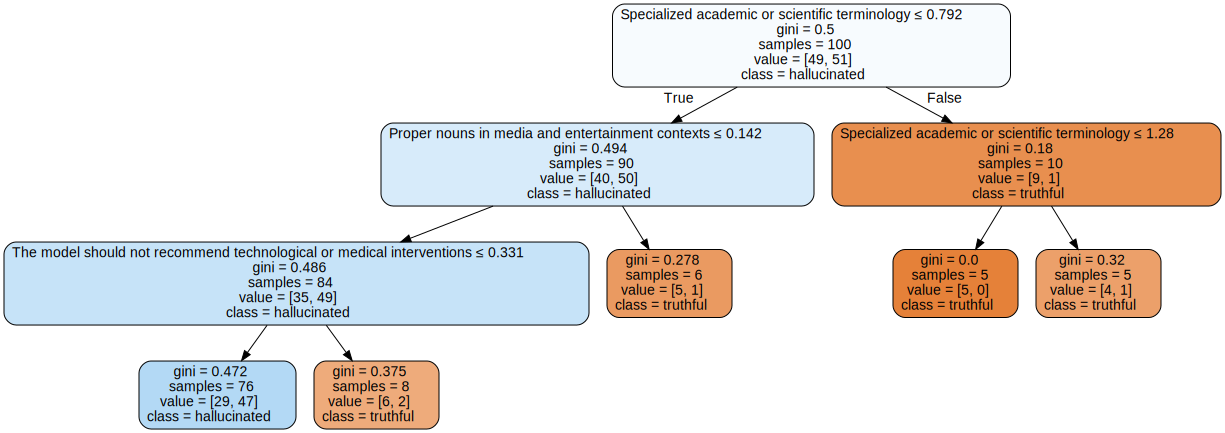

In [15]:
# Let's visualize the tree

import graphviz

dot_data = tree.export_graphviz(best_tree, out_file=None, feature_names=[feature.label for feature in best_features], class_names=['truthful', 'hallucinated'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [20]:
# let's inspect some feature activations for ourselves...

import concurrent.futures as futures
import tqdm

def get_feature_activations(client, variant, examples, features, k=50):
    """
    Get feature activations for a set of examples using Goodfire
    """
    samples = []

    with futures.ThreadPoolExecutor(max_workers=1) as executor:
        futures_list = []

        for example in examples:
            futures_list.append(
                executor.submit(
                    client.features.inspect,
                    example,
                    model=variant,
                    features=features,
                )
            )

        for future in tqdm.tqdm(futures_list):
            context = future.result()
            features = context.top(k=k)
            samples.append(features)

    return samples

In [21]:
dataset_1[0:1]

[[{'role': 'user',
   'content': 'You are a medical expert and this is a multiple choice exam question. Please respond with the integer index of the CORRECT answer only; [0,1,2,3].\n\nMental disorders in the Diagnostic and Statistical Manual of the American Psychiatric Association, following a personality disorder that belongs to the species (cluster) with three other different?\n\nOptions: {"0": "Borderline", "1": "Antisocial", "2": "Paranoid", "3": "Drama type"}'},
  {'role': 'assistant', 'content': '3'}]]

In [28]:
example_activations = get_feature_activations(client, variant, dataset_1[0:1], best_features)
example_activations

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


[FeatureActivations(
    0: (Feature("Specialized academic or scientific terminology"), 0.6015625)
    1: (Feature("The model should not recommend technological or medical interventions"), 0)
    2: (Feature("Proper nouns in media and entertainment contexts"), 0)
    3: (Feature("Mathematical derivation steps during integration problems"), 0)
    4: (Feature("Contrastive conjunctions balancing difficulties with solutions"), 0)
    5: (Feature("The model's turn to begin responding to user query"), 0)
    6: (Feature("The model is providing troubleshooting steps or guidance"), 0)
    7: (Feature("Punctuation marks used for pacing and engagement in teaching contexts"), 0)
    8: (Feature("The assistant is providing a list of options and asking for user selection"), 0)
    9: (Feature("The model's turn to speak"), 0)
    ...
    21: (Feature("The assistant is acknowledging or validating human emotions and experiences"), 0)
 )]

In [59]:
import pickle
import goodfire
from typing import List, Dict, Tuple, Any
import numpy as np

class HallucinationClassifier:
    def __init__(self, model_path: str, api_key: str):
        """
        Initialize the hallucination classifier with a saved model and features.
        
        Args:
            model_path: Path to the saved pickle file containing both the model and features
            api_key: Goodfire API key for accessing the service
        """
        # Load the model and features
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)
            self.model = model_data['model']
            self.features = model_data['features']
        self.client = goodfire.Client(api_key)
        self.variant = goodfire.Variant("meta-llama/Meta-Llama-3-8B-Instruct")

    def _format_prompt(self, question: str) -> List[Dict[str, str]]:
        """Format a question into the expected prompt structure."""
        introduction = ("You are a medical expert and this is a multiple choice exam question. "
                      "Please respond with the integer index of the CORRECT answer only; [0,1,2,3].")
        return [{"role": "user", "content": f"{introduction}\n\n{question}"}]

    def _get_feature_activations(self, prompt: List[Dict[str, str]]) -> List[float]:
        """Get feature activations for the input prompt."""
        context = self.client.features.inspect(
            prompt,
            model=self.variant,
            features=self.features
        )
        
        # Get activations for our specific features
        activations = []
        features_dict = {f.uuid: 0.0 for f in self.features}
        
        for feature_act in context.top(k=len(self.features)):
            if feature_act.feature.uuid in features_dict:
                features_dict[feature_act.feature.uuid] = feature_act.activation
        
        # Maintain order matching the original features
        for feature in self.features:
            activations.append(features_dict[feature.uuid])
            
        return activations

    def predict(self, question: str, debug: bool = False) -> Tuple[int, float]:
        """
        Predict whether a given question-answer pair is likely to contain hallucination.
        
        Args:
            question: The question text
            debug: If True, print debugging information about feature activations
            
        Returns:
            Tuple containing:
            - Prediction (0 for truthful, 1 for hallucinated)
            - Confidence score (probability of the predicted class)
        """
        # Format the prompt
        prompt = self._format_prompt(question)
        
        # Get feature activations
        activations = self._get_feature_activations(prompt)
        
        if debug:
            print("\nFeature Activations:")
            for feature, activation in zip(self.features, activations):
                print(f"{feature.label}: {activation:.4f}")
            
            # Get the decision path
            decision_path = self.model.decision_path([activations])
            feature_importance = self.model.feature_importances_
            
            print("\nFeature Importance in Model:")
            for feature, importance in zip(self.features, feature_importance):
                print(f"{feature.label}: {importance:.4f}")
            
            print("\nDecision Path:")
            node_indicator = decision_path[0]
            leaf_id = self.model.apply([activations])[0]
            
            # Get thresholds and feature indices for each node in path
            for node_id in node_indicator.indices:
                if node_id != leaf_id:
                    feature_idx = self.model.tree_.feature[node_id]
                    threshold = self.model.tree_.threshold[node_id]
                    feature_name = self.features[feature_idx].label
                    feature_value = activations[feature_idx]
                    print(f"Node {node_id}: {feature_name} = {feature_value:.4f} {'<=' if feature_value <= threshold else '>'} {threshold:.4f}")
        
        # Make prediction
        prediction = self.model.predict([activations])[0]
        probabilities = self.model.predict_proba([activations])[0]
        confidence = probabilities[prediction]
        
        if debug:
            print(f"\nProbabilities:")
            print(f"Truthful: {probabilities[0]:.4f}")
            print(f"Hallucinated: {probabilities[1]:.4f}")
        
        return int(prediction), float(confidence)


In [35]:
def save_model_and_features(model, features, output_path: str):
    """Save both the sklearn decision tree model and Goodfire features to a file.
    
    Args:
        model: The trained sklearn decision tree model
        features: The Goodfire features used by the model
        output_path: Path where to save the pickle file
    """
    model_data = {
        'model': model,
        'features': features
    }
    with open(output_path, 'wb') as f:
        pickle.dump(model_data, f)

In [39]:
# Save the model and best_features

model_path = "../assets/hallucination_model.pkl"
save_model_and_features(best_tree, best_features, model_path)



In [60]:
# Initialize the classifier (now simpler, no need to pass features separately)
classifier = HallucinationClassifier(
    model_path=model_path,
    api_key=api_key
)


In [65]:
# Make predictions - Example from hallucinations dataframe
prompt_example = hallucinated_examples.iloc[0]['prompt']
print(prompt_example)

prediction, confidence = classifier.predict(prompt_example, debug=True)

print(f"Prediction: {'Hallucinated' if prediction == 1 else 'Truthful'}")
print(f"Confidence: {confidence:.2f}")

You are a medical expert and this is a multiple choice exam question. Please respond with the integer index of the CORRECT answer only; [0,1,2,3].

Mental disorders in the Diagnostic and Statistical Manual of the American Psychiatric Association, following a personality disorder that belongs to the species (cluster) with three other different?

Options: {"0": "Borderline", "1": "Antisocial", "2": "Paranoid", "3": "Drama type"}

Feature Activations:
The model should not recommend technological or medical interventions: 0.0000
Specialized academic or scientific terminology: 0.6562
Proper nouns in media and entertainment contexts: 0.0000

Feature Importance in Model:
The model should not recommend technological or medical interventions: 0.2505
Specialized academic or scientific terminology: 0.5017
Proper nouns in media and entertainment contexts: 0.2479

Decision Path:
Node 0: Specialized academic or scientific terminology = 0.6562 <= 0.7922
Node 1: Proper nouns in media and entertainment

In [67]:
# Make predictions - Example from truthful dataframe

prompt_example = truthful_examples.iloc[50]['prompt']
print(prompt_example)

prediction, confidence = classifier.predict(prompt_example,debug=True)
print("Prediction: ", prediction)
print(f"Prediction: {'Hallucinated' if prediction == 1 else 'Truthful'}")
print(f"Confidence: {confidence:.2f}")

You are a medical expert and this is a multiple choice exam question. Please respond with the integer index of the CORRECT answer only; [0,1,2,3].

Oxygen saturation of venous blood is ?

Options: {"0": "30%", "1": "50%", "2": "70%", "3": "90%"}

Feature Activations:
The model should not recommend technological or medical interventions: 0.0000
Specialized academic or scientific terminology: 0.0000
Proper nouns in media and entertainment contexts: 0.0000

Feature Importance in Model:
The model should not recommend technological or medical interventions: 0.2505
Specialized academic or scientific terminology: 0.5017
Proper nouns in media and entertainment contexts: 0.2479

Decision Path:
Node 0: Specialized academic or scientific terminology = 0.0000 <= 0.7922
Node 1: Proper nouns in media and entertainment contexts = 0.0000 <= 0.1416
Node 2: The model should not recommend technological or medical interventions = 0.0000 <= 0.3314

Probabilities:
Truthful: 0.3816
Hallucinated: 0.6184
Predi

## EVALUATION ON TRAIN & TEST DATASETS

In [69]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def evaluate_model_predictions(classifier, truthful_examples, hallucinated_examples):
    """
    Evaluate model predictions across all examples.
    
    Args:
        classifier: The HallucinationClassifier instance
        truthful_examples: DataFrame containing truthful examples
        hallucinated_examples: DataFrame containing hallucinated examples
    """
    # Store results
    results = []
    
    # Process truthful examples
    print("\nProcessing truthful examples...")
    for idx, row in tqdm(truthful_examples.iterrows(), total=len(truthful_examples)):
        prediction, confidence = classifier.predict(row['prompt'])
        results.append({
            'true_label': 'truthful',
            'predicted': 'hallucinated' if prediction == 1 else 'truthful',
            'confidence': confidence
        })
    
    # Process hallucinated examples
    print("\nProcessing hallucinated examples...")
    for idx, row in tqdm(hallucinated_examples.iterrows(), total=len(hallucinated_examples)):
        prediction, confidence = classifier.predict(row['prompt'])
        results.append({
            'true_label': 'hallucinated',
            'predicted': 'hallucinated' if prediction == 1 else 'truthful',
            'confidence': confidence
        })
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    # Calculate overall statistics
    total_predictions = len(results_df)
    print("\nOverall Statistics:")
    print(f"Total examples evaluated: {total_predictions}")
    
    # Prediction distribution
    pred_dist = results_df['predicted'].value_counts()
    print("\nPrediction Distribution:")
    for pred, count in pred_dist.items():
        percentage = (count/total_predictions) * 100
        print(f"{pred}: {count} ({percentage:.1f}%)")
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    confusion = pd.crosstab(results_df['true_label'], results_df['predicted'])
    print(confusion)
    
    # Calculate metrics by class
    print("\nMetrics by True Label:")
    for label in ['truthful', 'hallucinated']:
        class_results = results_df[results_df['true_label'] == label]
        correct = (class_results['true_label'] == class_results['predicted']).sum()
        total = len(class_results)
        accuracy = (correct/total) * 100
        avg_confidence = class_results['confidence'].mean()
        
        print(f"\n{label.title()} Examples:")
        print(f"Accuracy: {accuracy:.1f}%")
        print(f"Average Confidence: {avg_confidence:.3f}")
    
    # Return the results DataFrame for further analysis if needed
    return results_df


### TRAIN DATASET EVALUATION

In [70]:
## TRAINING DATASET EVALUATION

# Assuming classifier is already initialized
results_df = evaluate_model_predictions(classifier, truthful_examples, hallucinated_examples)

# You can do additional analysis on results_df if needed
# For example, look at high confidence mistakes:
high_conf_mistakes = results_df[
    (results_df['true_label'] != results_df['predicted']) & 
    (results_df['confidence'] > 0.8)
]


Processing truthful examples...


100%|██████████| 100/100 [01:36<00:00,  1.03it/s]



Processing hallucinated examples...


100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


Overall Statistics:
Total examples evaluated: 200

Prediction Distribution:
hallucinated: 144 (72.0%)
truthful: 56 (28.0%)

Confusion Matrix:
predicted     hallucinated  truthful
true_label                          
hallucinated            86        14
truthful                58        42

Metrics by True Label:

Truthful Examples:
Accuracy: 42.0%
Average Confidence: 0.407

Hallucinated Examples:
Accuracy: 86.0%
Average Confidence: 0.548


### Train Performance Interpretation

The recall of 86% is quite good - the model catches 86% of all hallucinations. This aligns with your goal of preventing medical hallucinations, as it misses relatively few of them.
The precision of 59.7% means that when the model flags something as a hallucination, it's right about 60% of the time. The relatively lower precision indicates that the model is somewhat aggressive in flagging content as hallucinated.
This trade-off (high recall, moderate precision) might be acceptable for the medical use case, as:

In medical contexts, missing a hallucination (false negative) could be more dangerous than incorrectly flagging truthful content (false positive)
False positives can be manually reviewed, while missed hallucinations might go unnoticed

### TEST DATASET EVALUATION